In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.4.0


# FMCW Radar with a Corner Reflector

## Introduction

An FMCW (Frequency-Modulated Continuous Wave) radar is a type of radar system that uses frequency modulation to continuously transmit a signal with varying frequency. FMCW radar systems are commonly used in various applications, including automotive radar, weather monitoring, navigation, and industrial sensing. They offer several advantages over other radar types, such as pulsed radar.

Here's how FMCW radar works:

1. **Frequency Modulation**: In an FMCW radar, the radar transmitter emits a continuous waveform that changes frequency over time. This waveform is typically a sinusoidal signal. The frequency change occurs in a linear or ramp-like manner, hence the name "Frequency-Modulated Continuous Wave."

2. **Transmit and Receive Phases**: The radar emits the frequency-modulated signal, which travels towards the target. When the signal encounters an object, a portion of it gets reflected back towards the radar receiver.

3. **Mixing and Beat Frequency**: The reflected signal is mixed with the original transmitted signal in the radar receiver. Because the received signal has traveled a certain distance to the target and back, it experiences a frequency shift due to the Doppler effect and the frequency modulation of the transmitted signal. This frequency shift creates a beat frequency that is proportional to the distance and relative velocity of the target.

4. **Signal Processing**: By analyzing the beat frequency, the radar system can determine both the range (distance) and velocity of the target. The range is determined by the phase shift of the beat frequency, and the velocity is derived from the rate of change of the beat frequency over time.

Advantages of FMCW radar include:

1. **Continuous Operation**: FMCW radars operate continuously without interruptions, making them well-suited for tracking moving targets and providing real-time data.

2. **Range and Velocity Information**: FMCW radar can simultaneously provide information about the range and velocity of targets, making it useful for applications such as automotive collision avoidance and speed measurement.

3. **High Range Resolution**: FMCW radar systems can achieve high range resolution due to the continuous waveform and the use of frequency modulation.

4. **Simplicity and Cost-Effectiveness**: FMCW radar systems can be simpler and more cost-effective to implement compared to some other radar types, like pulsed radar.

5. **Adaptability to Multiple Targets**: FMCW radars can handle multiple targets within their field of view due to their continuous operation and the ability to separate different targets based on their individual beat frequencies.

Despite their advantages, FMCW radars also have limitations, such as reduced performance in certain cluttered environments and susceptibility to interference from other radar systems using similar frequencies. However, advancements in signal processing and technology have helped mitigate many of these challenges.

This illustration offers a simulation of an FMCW radar employing a trihedral corner reflector, implemented through the raytracing framework provided by [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/). Furthermore, it presents a practical demonstration of essential range and Doppler processing techniques, allowing the extraction of target range and velocity information, in addition to showcasing the two-dimensional CFAR technique.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [3]:
tx_channel = dict(
    location=(0, 0, 0),
)
tx = Transmitter(
    f=[77e9 - 50e6, 77e9 + 50e6],
    t=[0, 80e-6],
    tx_power=25,
    prp=100e-6,
    pulses=256,
    channels=[tx_channel],
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [4]:
rx_channel = dict(
    location=(0, 0, 0),
)
rx = Receiver(
    fs=2e6,
    noise_figure=8,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

## Corner Reflector Model

The corner reflector model is with `.stl`.


In [6]:
target_1 = {
    "model": "../models/cr.stl",
    "unit": "m",
    "location": (50, 0, 0),
    "speed": (-5, 0, 0),
}

targets = [target_1]

_Plot the 3D mesh of the corner reflector_


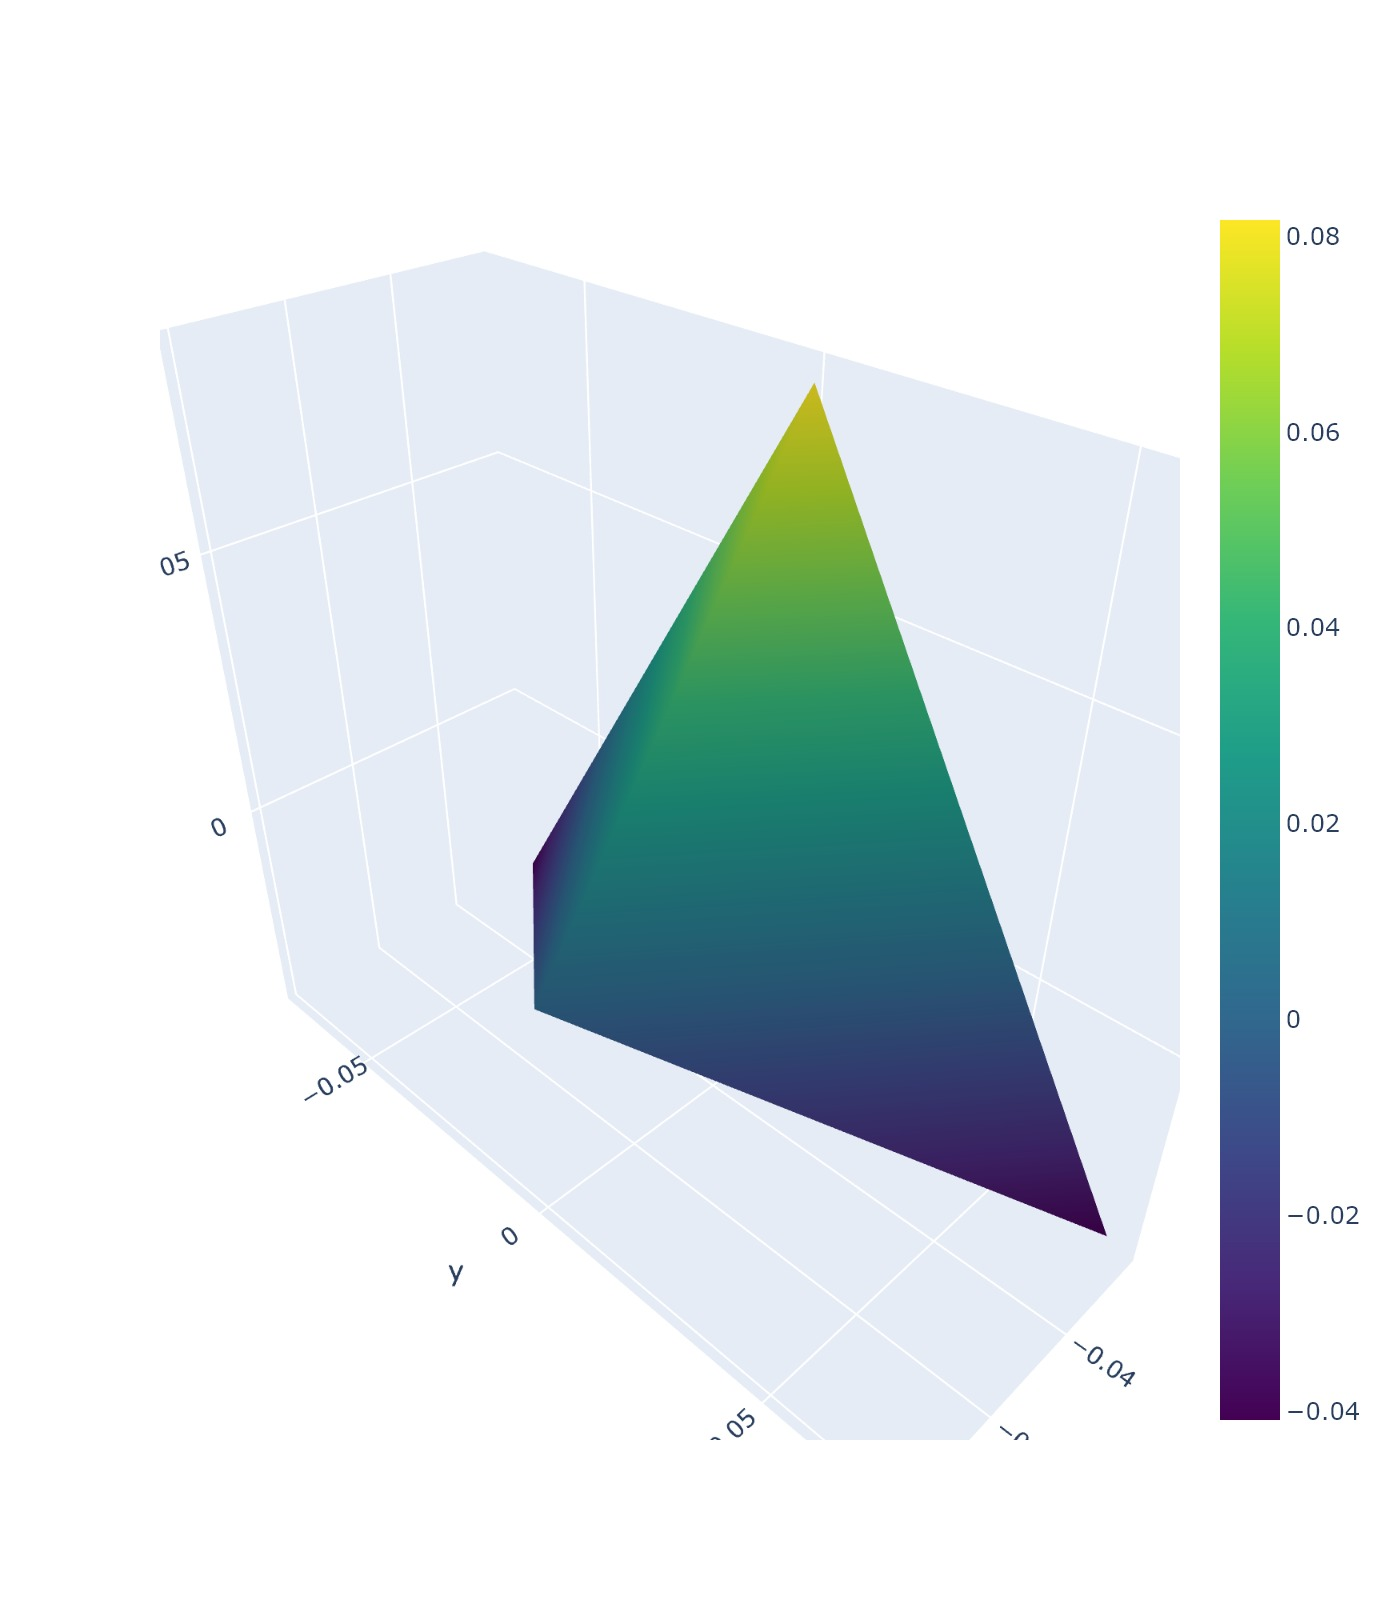

In [7]:
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())

fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [8]:
from radarsimpy.simulator import sim_radar
import time

tic = time.time()
data = sim_radar(radar, targets, density=0.2)

baseband = data["baseband"] + data["noise"]
toc = time.time()

print("Exec time:", toc - tic, "s")

Exec time: 0.23314857482910156 s


## Radar Signal Processing

### Range-Doppler processing


In [9]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=60)
doppler_window = signal.windows.chebwin(
    radar.radar_prop["transmitter"].waveform_prop["pulses"], at=60
)
range_doppler = proc.range_doppler_fft(baseband, rwin=range_window, dwin=doppler_window)

_Plot range-Doppler map_


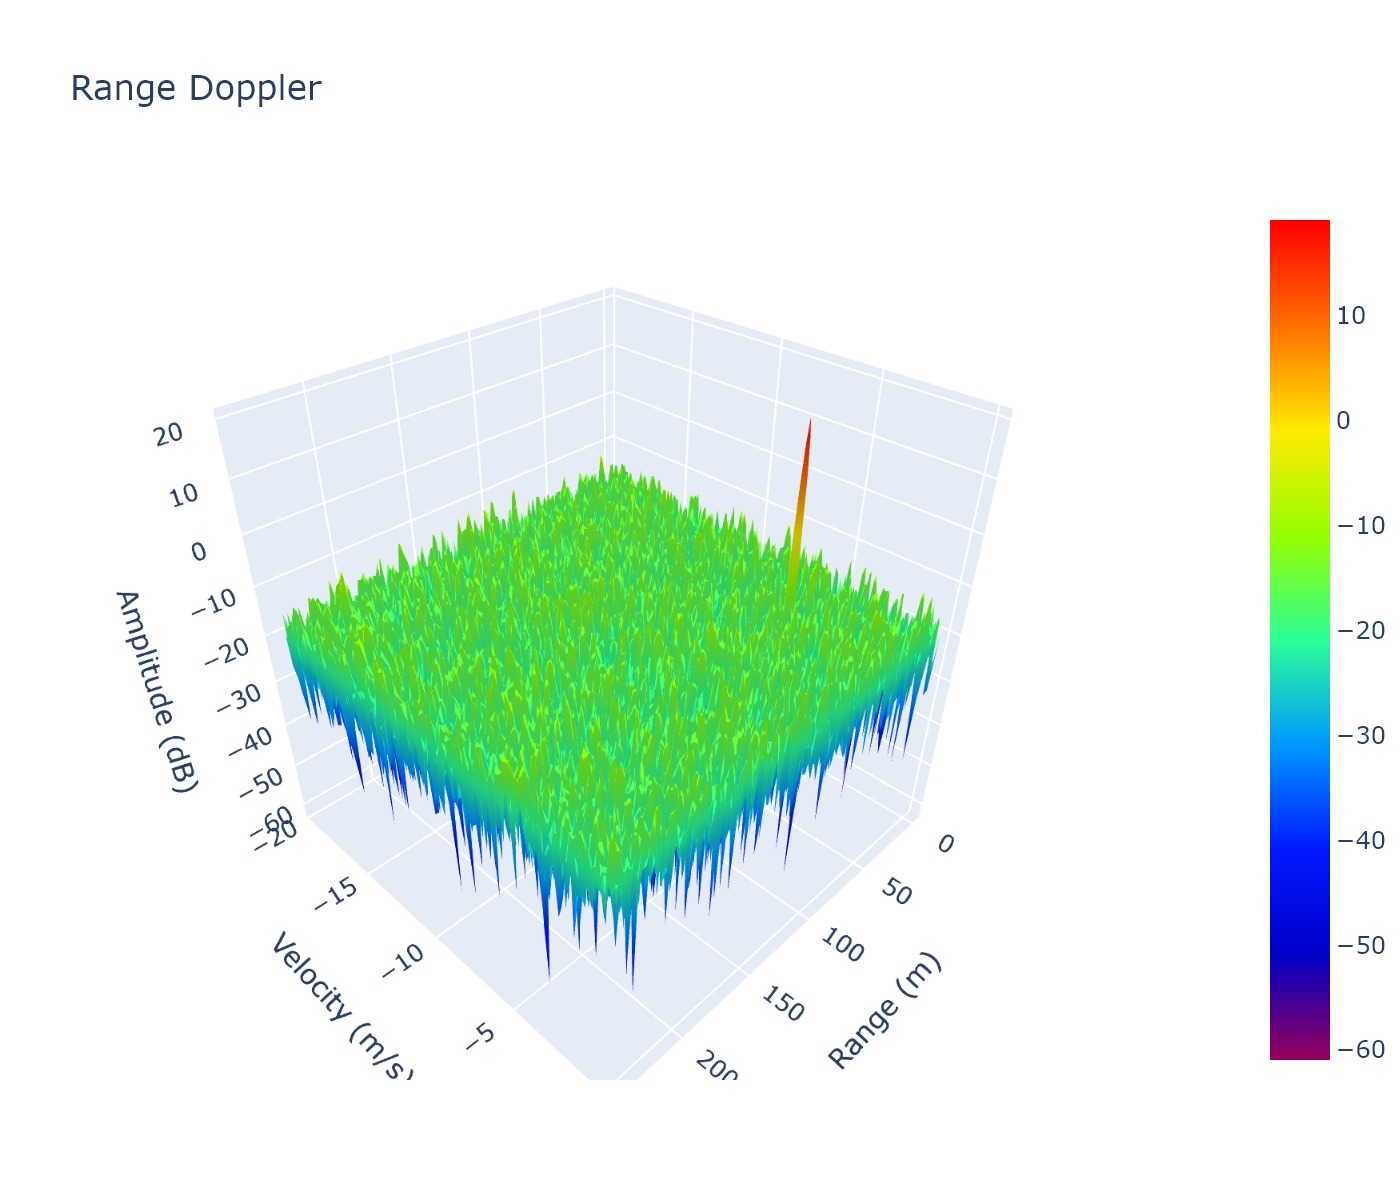

In [10]:
max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
unambiguous_speed = (
    3e8 / radar.radar_prop["transmitter"].waveform_prop["prp"][0] / 77e9 / 2
)

range_axis = np.linspace(
    0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False
)

doppler_axis = np.linspace(
    -unambiguous_speed,
    0,
    radar.radar_prop["transmitter"].waveform_prop["pulses"],
    endpoint=False,
)

fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=range_axis,
        y=doppler_axis,
        z=20 * np.log10(np.abs(range_doppler[0, :, :])),
        colorscale="Rainbow",
    )
)

fig.update_layout(
    title="Range Doppler",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)"),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### CFAR

The processing module of [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) incorporates both `CA-CFAR` and `OS-CFAR` algorithms. For 2-dimensional data, you can make use of [cfar_ca_2d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_ca_2d) and [cfar_os_2d](https://radarsimx.github.io/radarsimpy/process.html#radarsimpy.processing.cfar_os_2d).


In [11]:
rdop_avg = np.mean(np.abs(range_doppler), axis=0)
cfar = proc.cfar_os_2d(
    rdop_avg, guard=2, trailing=20, pfa=1e-4, k=1500, detector="linear"
)

_Plot range-Doppler map and CFAR_


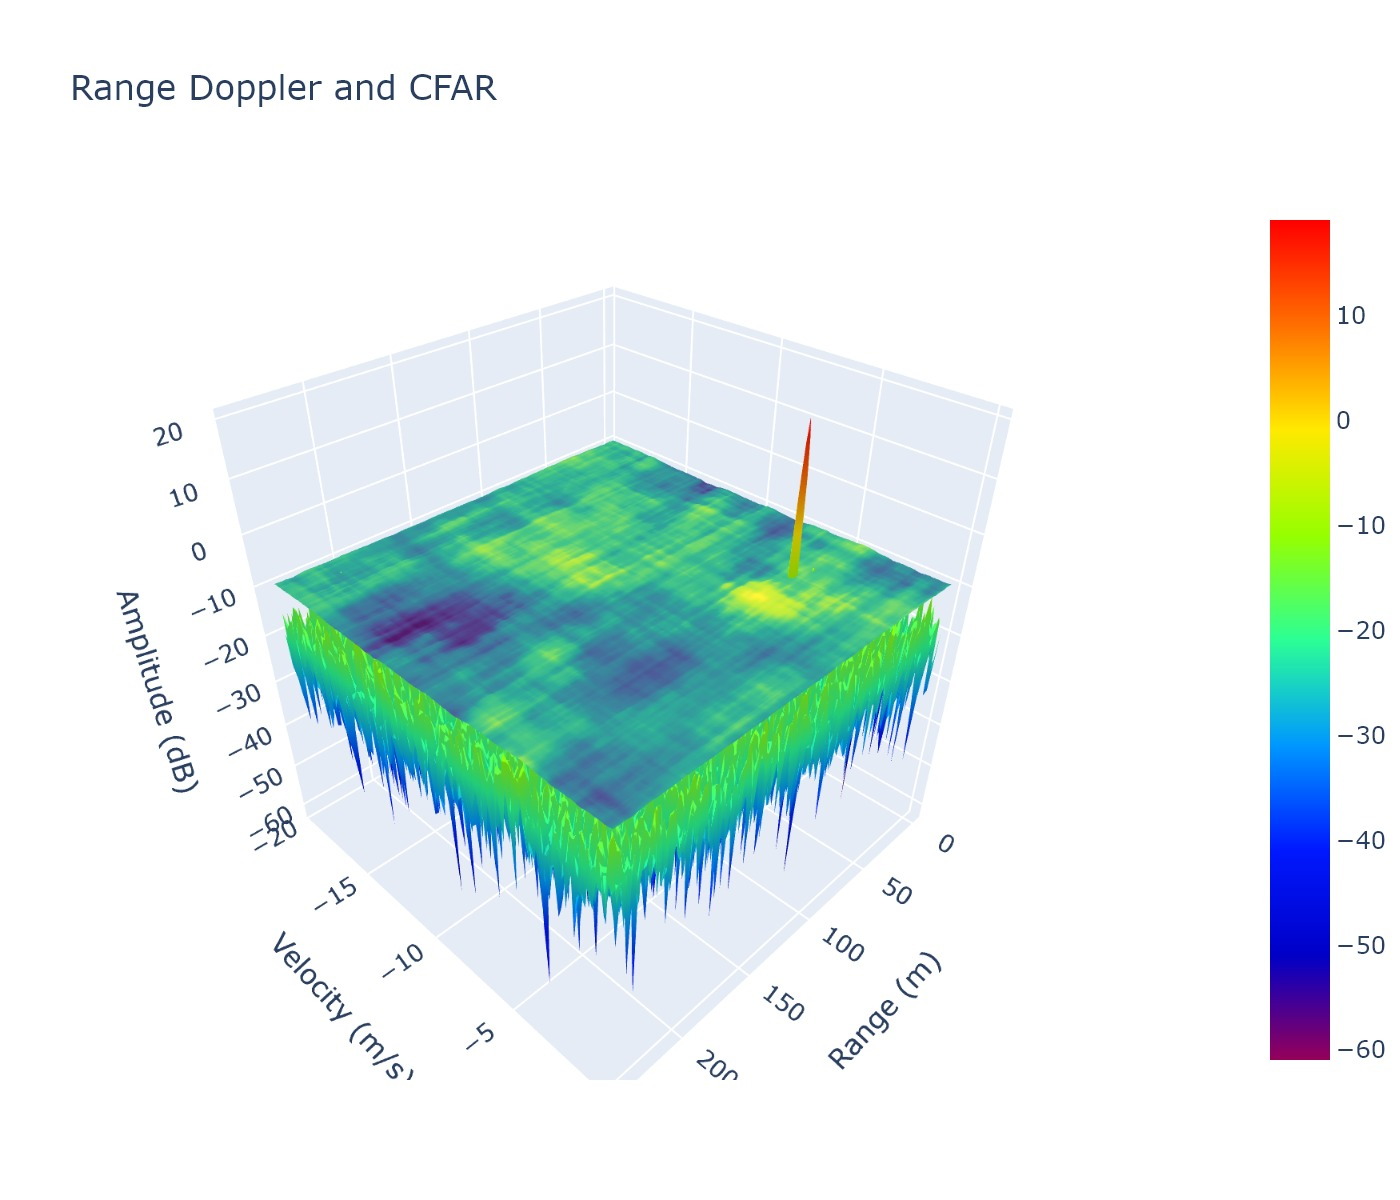

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Surface(
        x=range_axis, y=doppler_axis, z=20 * np.log10(rdop_avg), colorscale="Rainbow"
    )
)
fig.add_trace(
    go.Surface(
        x=range_axis,
        y=doppler_axis,
        z=20 * np.log10(cfar),
        colorscale="Viridis",
        showscale=False,
    )
)

fig.update_layout(
    title="Range Doppler and CFAR",
    height=600,
    scene=dict(
        xaxis=dict(title="Range (m)"),
        yaxis=dict(title="Velocity (m/s)"),
        zaxis=dict(title="Amplitude (dB)"),
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation="h"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))